## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape
x_train_original=x_train

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

Plotted the clusters for the train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [7]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

Preprocessed the train dataset by winsorizing and normalising the data.

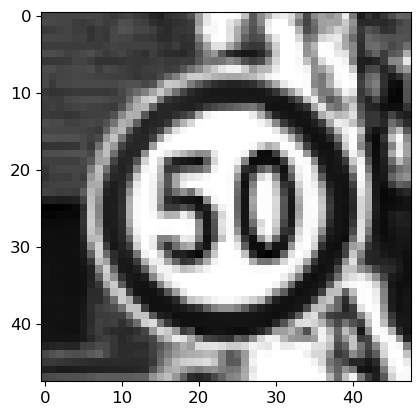

In [8]:
import matplotlib.pyplot as plt

img = x_train.iloc[4391]
img = img.values.reshape((48, 48))

plt.imshow(img, cmap='gray')
plt.show()

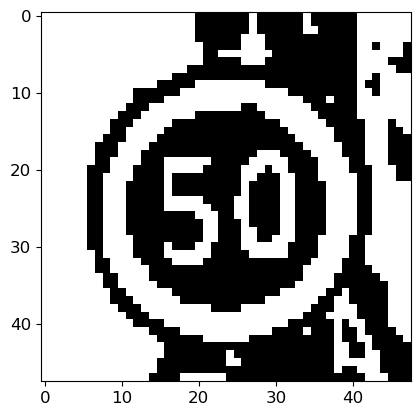

In [9]:
import cv2

ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh1,cmap='gray')

In [10]:
threshold_value = 120
threshold_img_xtrain = "thresholded_images"

In [11]:
x_train_o=x_train

In [12]:
# Create the output folder if it doesn't exist
if not os.path.exists(threshold_img_xtrain):
    os.makedirs(threshold_img_xtrain)

# Loop through the dataset and apply thresholding
for i in range(len(x_train)):
    img = x_train.iloc[i].values.reshape((48, 48))
    ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    cv2.imwrite(output_path, thresh1)

In [13]:
thresholded_images = []
for i in range(len(x_train)):
    img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresholded_images.append(img)

x_train = np.array(thresholded_images)

In [14]:
from scipy.stats.mstats import winsorize

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 50)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

Plotted the clusters again using PCA and also plotted the clusters using t-SNE for exploration.

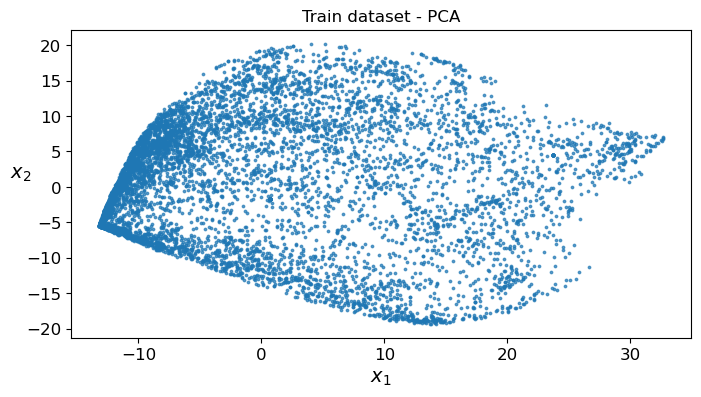

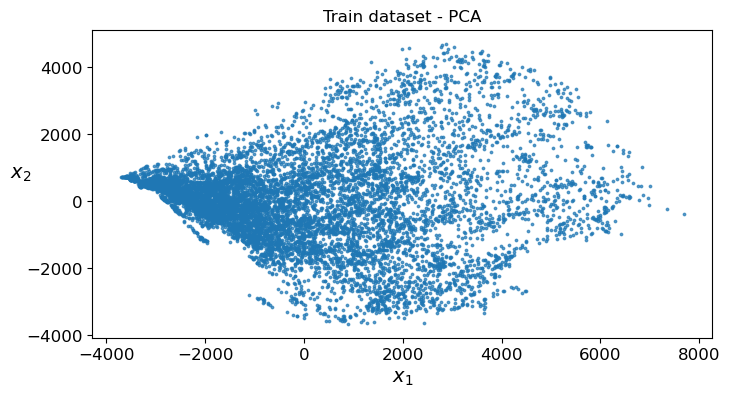

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train, y_train)
plot_figure("Train dataset - PCA", X_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_o, y_train)
plot_figure("Train dataset - PCA", X_pca)


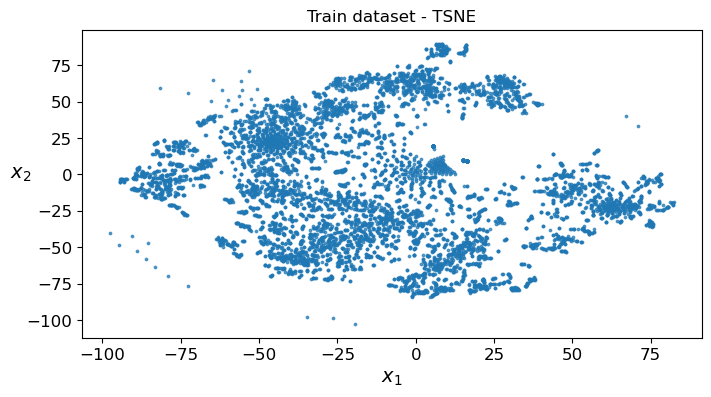

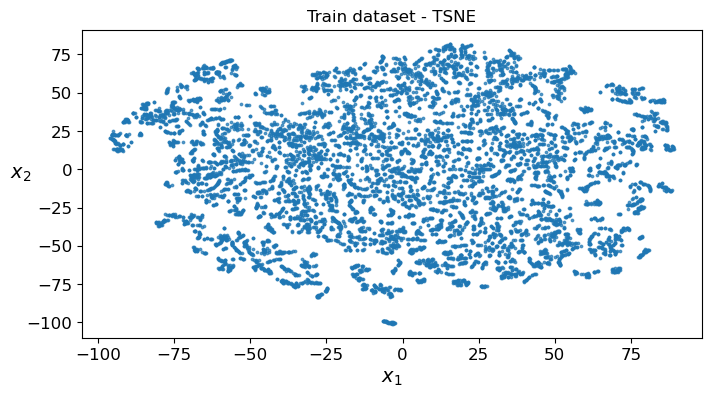

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

plot_figure("Train dataset - TSNE", x_train_tsne)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_o)

plot_figure("Train dataset - TSNE", x_train_tsne)

Applied K-Means clusterer on the dataset and received the silhouette score. Used k = 10 at the start, i.e., 10 clusters.

In [17]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_pca)

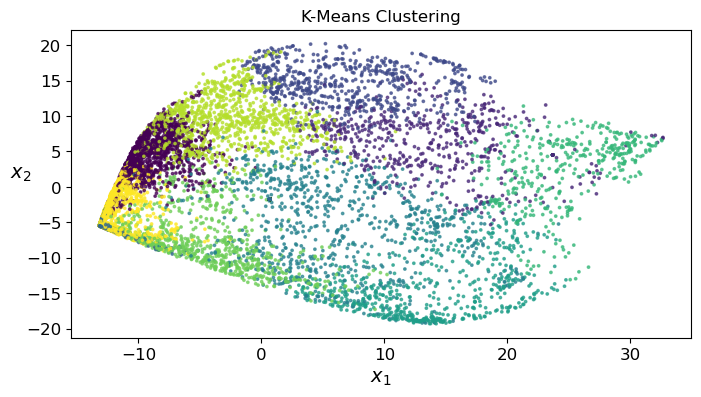

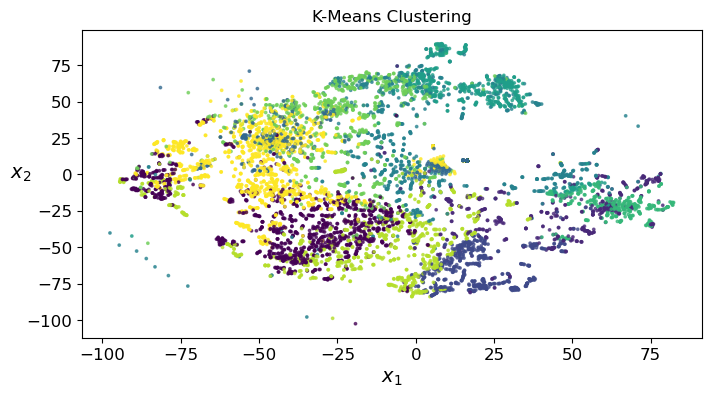

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
tsne = tsne.fit_transform(x_train)

plot_figure("K-Means Clustering", tsne, cluster_labels)

In [19]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels_on = kmeans.fit_predict(x_train_o)

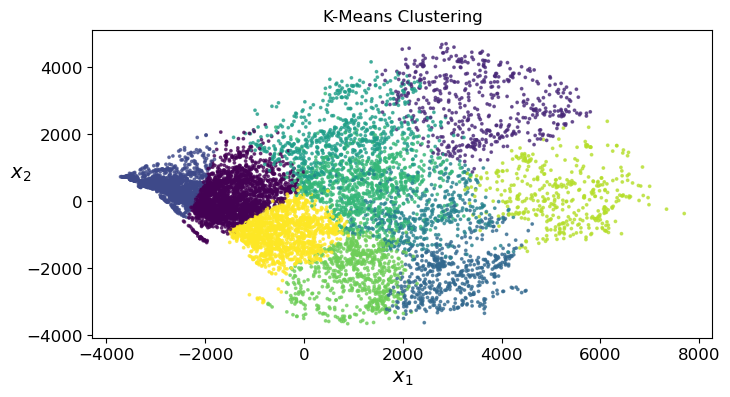

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca3 = pca.fit_transform(x_train_o)

plot_figure("K-Means Clustering", X_pca3, cluster_labels_on)

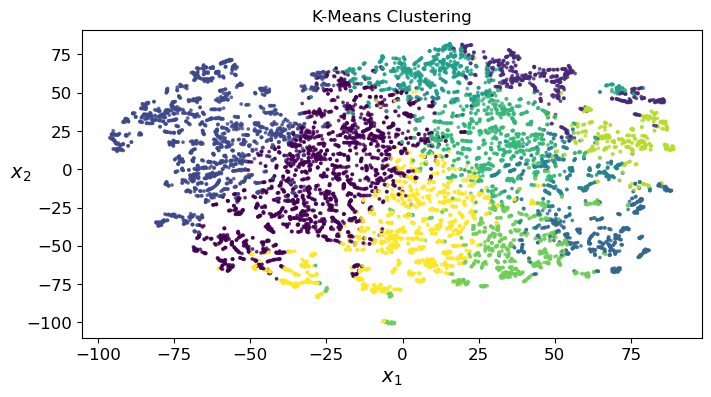

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
tsne = tsne.fit_transform(x_train_o)

plot_figure("K-Means Clustering", tsne, cluster_labels_on)

In [22]:
from sklearn.metrics import accuracy_score

y_train = np.asarray(y_train)

cluster_to_majority_class = {}
for cluster_label in np.unique(cluster_labels):
    cluster_mask = (cluster_labels == cluster_label)
    cluster_ground_truth_labels = y_train[cluster_mask].flatten()  
    majority_class = np.bincount(cluster_ground_truth_labels).argmax()
    cluster_to_majority_class[cluster_label] = majority_class

cluster_assigned_labels = [cluster_to_majority_class[label] for label in cluster_labels]

accuracy = accuracy_score(y_train, cluster_assigned_labels)  
print(f"Clustering Accuracy: {accuracy}")

Clustering Accuracy: 0.3448916408668731


In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

def calculate_metrics_and_mean(X_pca, y_train, y_true, model):
    report = classification_report(y_train, y_true, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_true)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    
    specificity = []
    unique_labels = np.unique(y_train)
    for i in range(len(unique_labels)):
        true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        total_negative = np.sum(cm) - np.sum(cm[i, :])
        specificity.append(true_negative / total_negative)
    specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    
    sensitivity = recall_score(y_train, y_true, average=None)
    sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    
    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_pca), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_true)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    cross_val_scores = cross_val_score(model, X_pca, y_train, cv=10)
    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})
    
    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df


In [24]:
calculate_metrics_and_mean(X_pca,y_train,cluster_assigned_labels,kmeans)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.344892,-6.945252e+08,1.659528e+08
1,0.364824,0.440090,0.398938,0.440090,0.227711,0.772289,0.440090,0.0,NaN,NaN,NaN
2,0.302767,0.651556,0.413424,0.651556,0.453763,0.546237,0.651556,0.0,NaN,NaN,NaN
3,0.440536,0.186525,0.262083,0.186525,0.040338,0.959662,0.186525,0.0,NaN,NaN,NaN
4,0.404323,0.321212,0.358007,0.321212,0.121530,0.878470,0.321212,0.0,NaN,NaN,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,NaN,NaN,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,NaN,NaN,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,NaN,NaN,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,NaN,NaN,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,NaN,NaN,NaN


In [25]:
cluster_labels

array([1, 1, 1, ..., 4, 4, 7])

In [26]:
cluster_labels is kmeans.labels_

False

In [27]:
kmeans.inertia_

37580116618.56605

In [28]:
kmeans.cluster_centers_

array([[ 55.89558059,  56.05415945,  55.76689775, ...,  41.57365685,
         41.65467938,  41.5992201 ],
       [242.1980198 , 241.18811881, 239.79207921, ..., 164.34059406,
        161.86732673, 160.58613861],
       [ 28.06833713,  27.78758542,  27.61503417, ...,  20.93109339,
         20.89179954,  21.06036446],
       ...,
       [ 71.90108401,  71.83604336,  71.01897019, ...,  59.77913279,
         60.51084011,  61.45528455],
       [204.08029197, 203.45742092, 204.88077859, ..., 188.26520681,
        188.70559611, 189.05109489],
       [ 58.51077137,  58.8533704 ,  59.07366227, ...,  49.22168172,
         49.41209173,  49.28700486]])

In [29]:
kmeans.labels_

array([6, 6, 6, ..., 5, 5, 5])

In [30]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.3589705199635517


In [31]:
# Reference : https://colab.research.google.com/drive/1wq7JGYCT6Ctgd572KN9_QuIJwCS9tNo5?usp=sharing#scrollTo=7ZtUIKwNEcFS
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [32]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels_on = kmeans.fit_predict(X_pca)

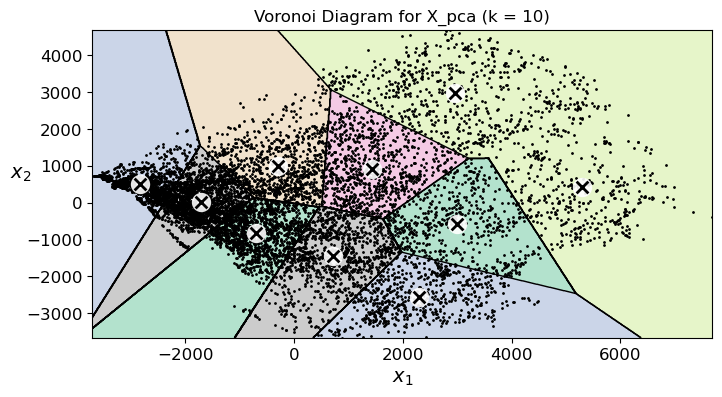

In [33]:
plt.figure(figsize=(8, 4))
plt.title("Voronoi Diagram for X_pca (k = 10)")
plot_decision_boundaries(kmeans, X_pca)
plt.show()

### 2) Hard & Soft Clustering

### 3) Determining Optimal Number of Clusters

In [34]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

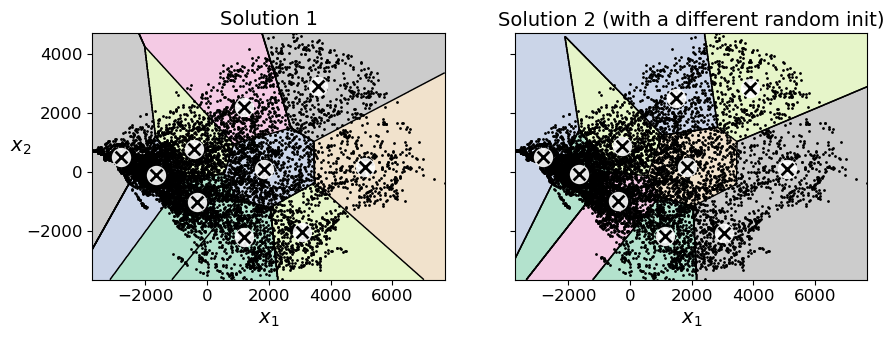

In [35]:
kmeans_rnd_init1 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=50)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_pca,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

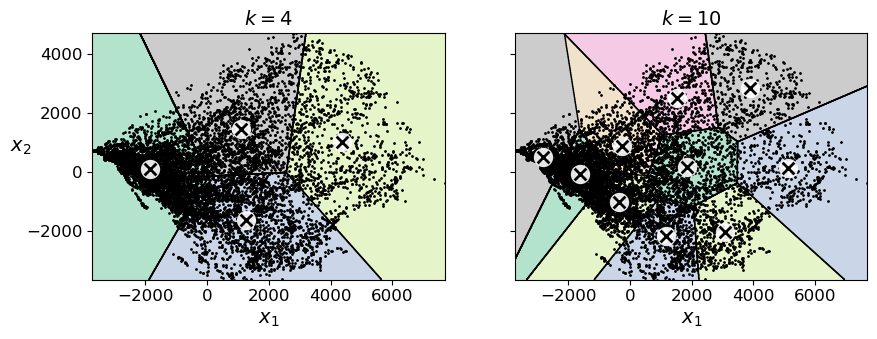

In [36]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_k10 = KMeans(n_clusters=10, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k4, kmeans_k10, X_pca, "$k=4$", "$k=10$")
plt.show()

In [37]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

(1.0, 13.0, 0.0, 67383792813.100945)

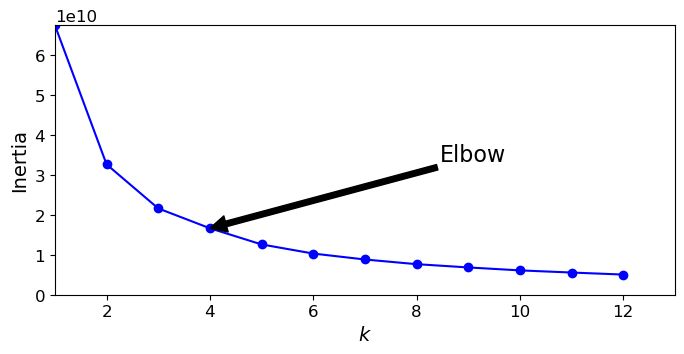

In [38]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_cluster), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=1)
            )
plt.axis([1, max_cluster, 0, max(inertias)])  


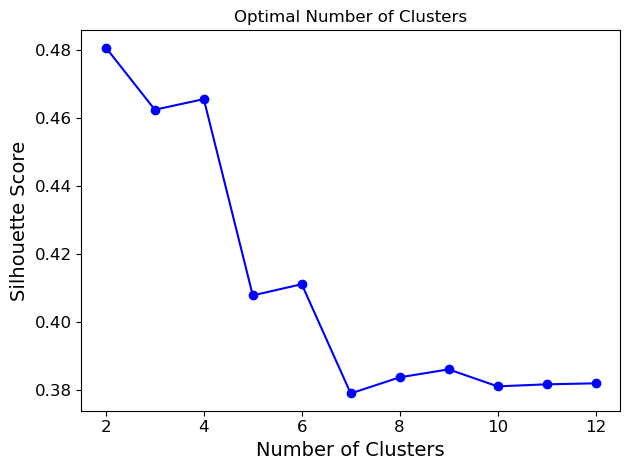

In [39]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()